In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as fit
import array
import sys
sys.path.insert(0, '/Users/sdporzio/HighVoltageTask')
import HvPackages.probability as prob
from HvPackages.dataFunctions import GetDateString as GDS
from HvPackages.dataFunctions import GetTimeString as GTS

In [23]:
leftLim = 1448148352 # 21 Nov
rightLim = 1454500456 # 3 Feb
nMonths = (rightLim - leftLim)/float((60*60*24*30))

fHV = open("Timestamps/hvBlipsFromData.dat")
fPMT = open("Timestamps/pmtHitsFromTorScopeMon.dat")
headerHV = fHV.readline()
headerPMT = fPMT.readline()
originTimeHV = array.array("d",[])
blipType = []
blipDuration = array.array("d",[])
blipIntensity = array.array("d",[])
originFilePMT = []
originTimePMT = array.array("d",[])
min1PMT = array.array("d",[])
min2PMT = array.array("d",[])
min3PMT = array.array("d",[])
min4PMT = array.array("d",[])

for line in fHV:
    x = line.split()
    if float(x[0]) > leftLim and float(x[0]) < rightLim:
        originTimeHV.append(float(x[0]))
        blipType.append(x[1])
        blipIntensity.append(float(x[5]))
        blipDuration.append(float(x[6]))

for line in fPMT:
    x = line.split()
    if float(x[1]) > leftLim and float(x[1]) < rightLim:
        originFilePMT.append(x[0])
        originTimePMT.append(float(x[1]))
        min1PMT.append(float(x[2]))
        min2PMT.append(float(x[3]))
        min3PMT.append(float(x[4]))
        min4PMT.append(float(x[5]))

In [24]:
maxCut = -200
minCut = 0
stepCut = 10

cutY_ar = array.array("d",[])
HV_ar = []
PMT_ar = []

for cutY in np.arange(maxCut,minCut,stepCut):
    cutY_ar.append(cutY)
    cutTimePMT = array.array("d",[])
    for i,timestampPMT in enumerate(originTimePMT):
        if min1PMT[i] < cutY and min2PMT[i] < cutY and min3PMT[i] < cutY and min4PMT[i] < cutY:
            cutTimePMT.append(float(timestampPMT))
    HV_ar.append(originTimeHV)
    PMT_ar.append(cutTimePMT)

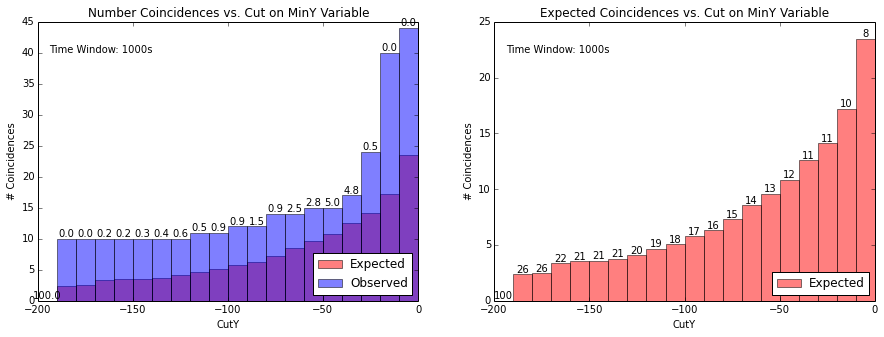

In [34]:
t = 1000 # Time Window in seconds

numC = array.array("I",[])
tWindow = array.array("d",[])
probC = array.array("d",[])
aveC = array.array("d",[])
probAveC = array.array("d",[])

for k,l in enumerate(cutY_ar):
    timeC = array.array("d",[])
    deltaC = array.array("d",[])
    for i,timestampHV in enumerate(HV_ar[k]):
        for j,timestampPMT in enumerate(PMT_ar[k]):
            deltaT = timestampPMT-timestampHV
            if abs(deltaT) < t:
                timeC.append(timestampHV)
                deltaC.append(deltaT)
    nCoinc = len(timeC)
    average = prob.average3(nMonths,t,len(HV_ar[k]),len(PMT_ar[k]))
    numC.append(nCoinc)
    probC.append(prob.prob3(nMonths,t,len(HV_ar[k]),len(PMT_ar[k]),nCoinc)*100)
    aveC.append(average)
    probAveC.append(prob.poissonian(average)*100)
    

fig = plt.figure(figsize=(15,5), dpi=80)
fig1 = fig.add_subplot(121)
fig1.bar(cutY_ar,aveC,stepCut,color="red",alpha=0.5,label='Expected')
fig1.bar(cutY_ar,numC,stepCut,color="blue",alpha=0.5,label='Observed')
for x,y,probs in zip(cutY_ar,numC,probC):
    fig1.text(x+stepCut/2., y, '%.1f' %probs, ha='center', va= 'bottom')
fig1.text(.03, .9,"Time Window: %.fs" %t, ha='left', va='center',fontsize=10,transform=fig1.transAxes)
fig1.legend(loc='lower right', frameon=True)
fig1.set_title("Number Coincidences vs. Cut on MinY Variable")
plt.xlabel('CutY')
plt.ylabel('# Coincidences')
plt.ylim(0,max(numC)+1)

fig2 = fig.add_subplot(122)
fig2.bar(cutY_ar,aveC,stepCut,color="red",alpha=0.5,label='Expected')
for x,y,probs in zip(cutY_ar,aveC,probAveC):
    fig2.text(x+stepCut/2., y, '%.f' %probs, ha='center', va= 'bottom')
fig2.text(.03, .9,"Time Window: %.fs" %t, ha='left', va='center',fontsize=10,transform=fig2.transAxes)
fig2.legend(loc='lower right', frameon=True)
fig2.set_title("Expected Coincidences vs. Cut on MinY Variable")
plt.xlabel('CutY')
plt.ylabel('# Coincidences')
plt.show()